<a href="https://colab.research.google.com/github/amitrappel/Anomaly-detection/blob/master/Hybrid_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install backtrader[plotting]
!pip install yfinance

     |████████████████████████████████| 419kB 2.6MB/s 
     |████████████████████████████████| 5.5MB 3.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=0e32c2282102b9186bc2ef4689c9cbcbd6a757af57c3a8c97d9ed9f90867ed99
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [135]:
from datetime import datetime
from random import choice
from collections import defaultdict
import backtrader as bt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

%matplotlib inline

# Select Stocks (static data)

In [16]:
fname = 'all_stocks_last_400.csv'

In [17]:
def get_history_data(filename):
    df = pd.read_csv('all_stocks_last_400.csv')
    df['dt'] = pd.to_datetime(df['Date'])   
    return df

In [18]:
def clean_data(df):
    df.drop(['Date', 'Dividends', 'Stock Splits', 'Adj Close', 'Volume'], axis=1, inplace=True)
    df = df[df['dt'].dt.year == 2019]
    return df

In [19]:
df = get_history_data(filename=fname)
df = clean_data(df)

In [20]:
df.sample(5)

,Open,High,Low,Close,Symbol,dt
122072,109.64,110.24,109.44,109.61,MDT,2019-11-22
177575,124.97,125.87,124.42,125.70,TT,2019-07-16
172161,373.14,373.97,370.99,373.23,TFX,2019-12-24
75161,85.76,87.35,85.26,87.08,FISV,2019-04-23
152807,35.57,35.93,35.46,35.62,PWR,2019-05-16


# Select stocks

## Option 1 - yearly return quantiles (rank)

In [91]:
def get_yearly_return(df_symbol):
    return 100*(df_symbol['Close'].iloc[-1] - df_symbol['Open'].iloc[0]) / df_symbol['Open'].iloc[0]

In [92]:
stocks = df.groupby('Symbol').apply(get_yearly_return).sort_values().to_frame(name='return')
stocks.sample(5)

,return
Symbol,
NWL,12.688822
HIG,42.527368
WFC,22.897527
JKHY,18.282729
ATVI,32.354260


In [93]:
n_quantiles = 7
quantiles = stocks['return'].quantile([i/n_quantiles for i in range(n_quantiles+1)])
stocks['Rank'] = pd.cut(stocks['return'], bins=quantiles, labels=range(1, n_quantiles+1))
stocks.sample(5)

,return,Rank
Symbol,,
AME,50.416477,6
ETR,45.027080,6
BBY,73.027633,7
WELL,24.159402,3
CAH,19.323326,3


In [134]:
rank = n_quantiles  # best quantile
group_stocks = stocks[stocks['Rank'] == rank].index.tolist()
group_stocks[10:15]

['NVR', 'SYF', 'INFO', 'ALLE', 'FISV']

## Option 2 - business

# Get the data (*yfinance* & *backtracder*)

In [100]:
my_stock = choice(rank_stocks)
my_stock

'CPB'

In [101]:
def get_contract(stock):
    contract = yf.Ticker(stock)
    contract_history = contract.history(start ='2019-01-01',
                                        end='2020-01-01',  
                                        interval='1d')
    data_pd = bt.feeds.PandasData(dataname=contract_history)
    return contract_history, data_pd

In [102]:
contract_history, data_pd = get_contract(my_stock)

In [103]:
contract_history.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,30.717235,30.829755,30.032755,30.248413,3518900,0.00,0
2019-01-03,30.210910,31.017285,30.089015,30.623472,3312900,0.00,0
2019-01-04,30.585971,31.045418,30.360938,30.792253,2520400,0.00,0
2019-01-07,30.689109,31.786155,30.407816,31.589247,3543600,0.00,0
2019-01-08,31.589246,31.977716,31.342901,31.826118,2296900,0.35,0


In [104]:
data_pd

# Define strategies

## Option 1 - Test strategy

> **Reference:** Taken from [backtrader quickstart docs](https://www.backtrader.com/docu/quickstart/quickstart/)

In [105]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

## Option 2 - SMA crossing

In [106]:
class SmaCross(bt.SignalStrategy):
    params = (('fast',10),
              ('slow',30),
             )
    def __init__(self):
        self.sma_fast = bt.ind.SMA(period=self.params.fast)
        self.sma_slow = bt.ind.SMA(period=self.params.slow)

    def start(self):
        pass

    
    def next(self):
        if self.position.size == 0:
            if self.sma_fast  > self.sma_slow:
                self.buy()
        elif self.position.size != 0:
            if self.sma_fast < self.sma_slow:
                self.sell()

    def stop(self):
        pass 
        
    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                pass
            else:  # Sell
                pass        

## Option 3 - TBD (LSTM?)

# Apply startegy

## Cerebro

In [109]:
cerebro = bt.Cerebro()

In [114]:
my_cash = 100000
cerebro.broker.setcash(my_cash)

In [110]:
fast = 10
slow = 30
hyper_parameters = {'fast': fast, 'slow': slow}

In [111]:
cerebro.addstrategy(SmaCross, **hyper_parameters)
# cerebro.addstrategy(TestStrategy)

0

In [112]:
cerebro.adddata(data_pd)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 90)
# cerebro.addwriter(bt.WriterFile, out=None ,csv=True)

In [113]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Starting Portfolio Value: 118137.87


## Single stock

In [119]:
def apply_strategy(strategy, data, cash=100000, **hyper_parameters):
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(cash)
    cerebro.addstrategy(strategy, **hyper_parameters)
    cerebro.adddata(data)
    cerebro.addsizer(bt.sizers.PercentSizer, percents = 90)
    cerebro.run()
    profit = cerebro.broker.getvalue() - cash
    return profit

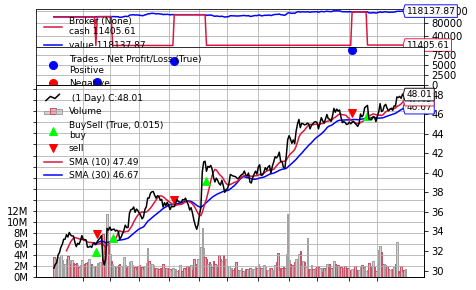

In [120]:
# cerebro.plot()[0][0]

> **Note:** This is for the SmcCross strategy. Other strategies will use different hyper-parameters.

In [132]:
for fast in [3, 5, 10]:
    for slow in [10, 15, 20, 30]:
        if fast < slow:
            my_hyper_parameters = {'fast': fast, 'slow': slow}
            profit = apply_strategy(strategy=SmaCross, 
                                    data=data_pd, 
                                    cash=my_cash,
                                    **my_hyper_parameters)
            print(f'{my_hyper_parameters}: {profit/my_cash:.2%}')

{'fast': 3, 'slow': 10}: -6.72%
{'fast': 3, 'slow': 15}: -5.11%
{'fast': 3, 'slow': 20}: -1.09%
{'fast': 3, 'slow': 30}: 13.22%
{'fast': 5, 'slow': 10}: -16.99%
{'fast': 5, 'slow': 15}: 5.45%
{'fast': 5, 'slow': 20}: -0.41%
{'fast': 5, 'slow': 30}: 8.43%
{'fast': 10, 'slow': 15}: 13.22%
{'fast': 10, 'slow': 20}: 8.84%
{'fast': 10, 'slow': 30}: 18.14%


## Multiple stocks

In [147]:
profits = defaultdict(int)
for fast in [3, 5, 10]:
    for slow in [10, 15, 20, 30]:
        if fast < slow:
            print('\n', fast, slow, end=' ')
            for my_stock in group_stocks:
                print(my_stock, end=' ')
                _, data_pd = get_contract(my_stock)

                my_hyper_parameters = {'fast': fast, 'slow': slow}
                stock_profit = apply_strategy(strategy=SmaCross,
                                            data=data_pd, 
                                            cash=my_cash,
                                            **my_hyper_parameters)
                profits[(fast, slow)] += stock_profit


 3 10 CPB DHI FLT ODFL J ZTS PLD HLT APTV FB NVR SYF INFO ALLE FISV EL MSFT GRMN FMC MA C NOW CDNS QCOM SPGI ZBRA CTAS WU KSU STX AMP URI MLM CAG KEYS DOV SNPS MAS EQIX TIF HES BBY CHTR MU MCO TSN FBHS GPN MSCI NVDA WDC CDW COTY MKTX ANSS TDG DXCM SWKS LDOS AAPL CPRT AMAT QRVO XRX CMG IR TGT KLAC PAYC LRCX ETN AMD 
 3 15 CPB DHI FLT ODFL J ZTS PLD HLT APTV FB NVR SYF INFO ALLE FISV EL MSFT GRMN FMC MA C NOW CDNS QCOM SPGI ZBRA CTAS WU KSU STX AMP URI MLM CAG KEYS DOV SNPS MAS EQIX TIF HES BBY CHTR MU MCO TSN FBHS GPN MSCI NVDA WDC CDW COTY MKTX ANSS TDG DXCM SWKS LDOS AAPL CPRT AMAT QRVO XRX CMG IR TGT KLAC PAYC LRCX ETN AMD 
 3 20 CPB DHI FLT ODFL J ZTS PLD HLT APTV FB NVR SYF INFO ALLE FISV EL MSFT GRMN FMC MA C NOW CDNS QCOM SPGI ZBRA CTAS WU KSU STX AMP URI MLM CAG KEYS DOV SNPS MAS EQIX TIF HES BBY CHTR MU MCO TSN FBHS GPN MSCI NVDA WDC CDW COTY MKTX ANSS TDG DXCM SWKS LDOS AAPL CPRT AMAT QRVO XRX CMG IR TGT KLAC PAYC LRCX ETN AMD 
 3 30 CPB DHI FLT ODFL J ZTS PLD HLT APTV FB NVR

In [152]:
sorted(map(lambda tup: (tup[1]/my_cash, tup[0]), profits.items()), reverse=True)

[(23.927685850311033, (10, 15)),
 (22.68414722262608, (5, 15)),
 (22.668352307162426, (3, 15)),
 (22.541099819828506, (5, 10)),
 (22.2582690623999, (3, 10)),
 (20.78933477271747, (10, 20)),
 (19.250244325431144, (5, 20)),
 (18.776499788557796, (3, 20)),
 (15.73255678672307, (10, 30)),
 (15.182813450305265, (5, 30)),
 (14.359082235418843, (3, 30))]